<a href="https://colab.research.google.com/github/blackbtccollins/AIML_Training/blob/main/class/Blackburn_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST Competition!
**Author**: W. Tod Newman

**Updates**: New Version

## Problem

Classify images from the "Fashion MNIST" data set.   Optimize the test accuracy.

## Metrics

This competition is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:![alt text](https://user-images.githubusercontent.com/26015273/41822460-2ca0a90a-77f0-11e8-9c71-7e88fa6b5c61.gif)


The double sum is over the observations `i`, whose number is `N`, and the categories `c`, whose number is `C`. The term `1_{y_i \in C_c}` is the indicator function of the `i`th observation belonging to the `c`th category. The `p_{model}[y_i \in C_c]` is the probability predicted by the model for the `i`th observation to belong to the `c`th category. When there are more than two categories, the neural network outputs a vector of `C` probabilities, each giving the probability that the network input should be classified as belonging to the respective category. When the number of categories is just two, the neural network outputs a single probability `\hat{y}_i`, with the other one being `1` minus the output. This is why the binary cross entropy looks a bit different from categorical cross entropy, despite being a special case of it.

## Dataset

This dataset is the Fashion MNIST dataset

Recently, the researchers at Zalando, an e-commerce company, introduced Fashion MNIST as a drop-in replacement for the original MNIST dataset. Like MNIST, Fashion MNIST consists of a training set consisting of 60,000 examples belonging to 10 different classes and a test set of 10,000 examples. Each training example is a gray-scale image, 28x28 in size. The authors of the work further claim that the Fashion MNIST should actually replace MNIST dataset for benchmarking of new Machine Learning or Computer Vision models.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

The Labels are:  
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot 

## Objective

In this competition, you can try different variations of the CNN model given as a reference, you may evaluate techniques to squeeze more performance out of a CNN, or you might even try a completely different model, neural network or otherwise.  You will note that there are tips/tricks/techniques documented in many locations on the internet that could be useful.

## Rules and Timeline

The primary measure for the competition will be the accuracy of prediction on the test data.  Ties will be broken by Precision accuracy first, then Recall Accuracy if needed.

The results will be revealed at the end of the last day of class.  Please submit your Metrics blocks (Starts with SUBMIT... and ends with END SUBMISSION) to instructors (wtnewman@raytheon.com) before lunch.

A prize will be given to the top finisher(s) based on the judgement of the instructor and the availability of prizes.


In [27]:
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,  Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard,  ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
import os
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

## Set Up Variables

In [28]:
epochs = 100                 # Number of Training Epochs
num_classes = 10            # This is the number of classes in the Fashion MNIST dataset
batch_size = 300          # This parameter can be adjusted
img_rows, img_cols = 28, 28 # Pixel sizes of the Images in the Dataset

## Gather and Process Fashion MNIST data

1. First, collect the data from Keras (our goal is someday that our organizational data is this easy to get!)
2. Then split into train and test sets.
3. Next we need to process the data into the proper shape for the CNN
4. Then scale the floats to land between 0 and 1.  Often times we use sklearn's MinMaxScaler for this, but in this case we're going for simplicity.
5. Next take the y_train and y_test labels and encode them one-hot.  This will enable the CNN to function.

In [29]:
# Grab the data from the keras repository

mnist_data = fashion_mnist.load_data()
x = mnist_data[0][0]
y = mnist_data[0][1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=41)

# Process the date into the right tensor shape.  This is a good practice, but
# usually tensorflow uses channels last (the 'else' here)

if K.image_data_format() == "channels first":
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
#
#  Cast to a 32 bit float and then scale so the value is a float between 0 and 1
    
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

#
# Convert Class Vector to Binary Class Matrices (one-hot encoding).
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

#
# Function to decode one-hot encoding later on when we want to evaluate performance.
def decode_one_hot(y):
    y_classes = [np.argmax(yi, axis=None, out=None) for yi in y]
    return y_classes

'''

Below we're experimenting with the Keras ImageDataGenerator.  From my experience, if these parameters
are set too aggressively, the loss/accuracy will either never improve or it will take too long to improve.
Below is an example of a complex data augmentation regime.  This is just for reference.  See my more simple
one at the bottom.

    
datagen = ImageDataGenerator(rotation_range=0.5, 
                                 zoom_range=0.1,
                                 featurewise_center=True,
                                 #featurewise_std_normalization=True,
                                 width_shift_range=0.1, 
                                 height_shift_range=0.1, 
                                 shear_range=0.1,
                                 horizontal_flip=True, 
                                 fill_mode="nearest")
'''
#
#  Set up our Image Augmentation Data Generator
#
datagen = ImageDataGenerator(rotation_range=5)
datagen.fit(x_train)

(19800, 10)


## Build the Model

* In this example, we define the below block as a Sequential Model. 
* See the excellent [Keras Documentation](https://keras.io/guides/sequential_model/) on Sequential Models for info.
* Many of these parameters can be experimented with.  The documentation will help you understand how much to experiment.

In [30]:
#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#

###Best####

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 #kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(Dropout(0.7))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3,3)))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.6))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(800))  
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))

my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]


In [31]:
#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#

###BEST - Save ####

#model = Sequential()
#
#model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape))
#model.add(Dropout(0.3))
#model.add(Activation('relu'))
#model.add(Conv2D(64, kernel_size=(3,3)))
#model.add(LeakyReLU(alpha=0.05))
#model.add(Dropout(0.2))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Activation('relu'))
#model.add(Flatten())
#model.add(Dense(100))  
#model.add(Activation('relu'))
#model.add(Dropout(0.1))
#model.add(Dense(num_classes, activation="softmax"))
#
#my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]

## Fit and Evaluate the Model

In [32]:
# Flag to determine whether we use Keras' Image augmentation data generator
augmentation = False

#
# Compile the model so we can fit it. Researching loss functions and optimizers
# might be a good thing to do.
#
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

if not augmentation:
    #
    # Fit the model.  Once the model is trained we'll evaluate the performance.
    print('not using image augmentation')
    hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=my_callbacks)
else:
# fits the model on batches with real-time data augmentation:
    hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch=len(x_train) / batch_size, validation_data=(x_test, y_test),
                           epochs=epochs, verbose=1, callbacks=my_callbacks, workers = 2)


score = model.evaluate(x_test, y_test)

#
# Predict on the test data and pass to metrics function
yhat = np.argmax(model.predict(x_test), axis=-1)
y_dec = decode_one_hot(y_test)

print("\nSUBMIT THIS BLOCK for the Competition\n")
print(metrics.classification_report(y_dec, yhat))
print("Testing Loss:", score[0])
print("Testing Accuracy:", score[1])
print("END SUBMISSION BLOCK\n")

model.summary()



not using image augmentation
Epoch 1/100
133/134 [============================>.] - ETA: 0s - loss: 0.7020 - accuracy: 0.7476

134/134 [==============================] - 4s 30ms/step - loss: 0.7001 - accuracy: 0.7483 - val_loss: 0.6660 - val_accuracy: 0.8421
Epoch 2/100
133/134 [============================>.] - ETA: 0s - loss: 0.4311 - accuracy: 0.8427

134/134 [==============================] - 4s 27ms/step - loss: 0.4311 - accuracy: 0.8427 - val_loss: 0.5033 - val_accuracy: 0.8706
Epoch 3/100
133/134 [============================>.] - ETA: 0s - loss: 0.3715 - accuracy: 0.8655

134/134 [==============================] - 4s 27ms/step - loss: 0.3713 - accuracy: 0.8654 - val_loss: 0.4128 - val_accuracy: 0.8803
Epoch 4/100
133/134 [============================>.] - ETA: 0s - loss: 0.3328 - accuracy: 0.8773

134/134 [==============================] - 4s 27ms/step - loss: 0.3321 - accuracy: 0.8775 - val_loss: 0.3785 - val_accuracy: 0.8815
Epoch 5/100
134/134 [==============================] - ETA: 0s - loss: 0.3110 - accuracy: 0.8855

134/134 [==============================] - 4s 27ms/step - loss: 0.3110 - accuracy: 0.8855 - val_loss: 0.3472 - val_accuracy: 0.8983
Epoch 6/100
133/134 [============================>.] - ETA: 0s - loss: 0.2949 - accuracy: 0.8916

134/134 [==============================] - 4s 27ms/step - loss: 0.2951 - accuracy: 0.8915 - val_loss: 0.3242 - val_accuracy: 0.8943
Epoch 7/100
133/134 [============================>.] - ETA: 0s - loss: 0.2791 - accuracy: 0.8950

134/134 [==============================] - 4s 27ms/step - loss: 0.2789 - accuracy: 0.8952 - val_loss: 0.3203 - val_accuracy: 0.9044
Epoch 8/100
134/134 [==============================] - ETA: 0s - loss: 0.2612 - accuracy: 0.9021

134/134 [==============================] - 4s 27ms/step - loss: 0.2612 - accuracy: 0.9021 - val_loss: 0.3002 - val_accuracy: 0.8997
Epoch 9/100
132/134 [============================>.] - ETA: 0s - loss: 0.2511 - accuracy: 0.9059

134/134 [==============================] - 4s 28ms/step - loss: 0.2507 - accuracy: 0.9061 - val_loss: 0.2832 - val_accuracy: 0.9059
Epoch 10/100
133/134 [============================>.] - ETA: 0s - loss: 0.2412 - accuracy: 0.9093

134/134 [==============================] - 4s 28ms/step - loss: 0.2416 - accuracy: 0.9091 - val_loss: 0.2795 - val_accuracy: 0.9085
Epoch 11/100
134/134 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.9123

134/134 [==============================] - 4s 29ms/step - loss: 0.2333 - accuracy: 0.9123 - val_loss: 0.2792 - val_accuracy: 0.9086
Epoch 12/100
133/134 [============================>.] - ETA: 0s - loss: 0.2205 - accuracy: 0.9166

134/134 [==============================] - 4s 27ms/step - loss: 0.2204 - accuracy: 0.9167 - val_loss: 0.2661 - val_accuracy: 0.9120
Epoch 13/100
133/134 [============================>.] - ETA: 0s - loss: 0.2141 - accuracy: 0.9191

134/134 [==============================] - 4s 29ms/step - loss: 0.2140 - accuracy: 0.9192 - val_loss: 0.2611 - val_accuracy: 0.9102
Epoch 14/100
132/134 [============================>.] - ETA: 0s - loss: 0.2044 - accuracy: 0.9233

134/134 [==============================] - 4s 27ms/step - loss: 0.2051 - accuracy: 0.9232 - val_loss: 0.2501 - val_accuracy: 0.9161
Epoch 15/100
134/134 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.9247

134/134 [==============================] - 4s 27ms/step - loss: 0.1977 - accuracy: 0.9247 - val_loss: 0.2418 - val_accuracy: 0.9154
Epoch 16/100
134/134 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9282

134/134 [==============================] - 4s 29ms/step - loss: 0.1879 - accuracy: 0.9282 - val_loss: 0.2435 - val_accuracy: 0.9182
Epoch 17/100
133/134 [============================>.] - ETA: 0s - loss: 0.1827 - accuracy: 0.9299

134/134 [==============================] - 4s 28ms/step - loss: 0.1826 - accuracy: 0.9300 - val_loss: 0.2378 - val_accuracy: 0.9175
Epoch 18/100
134/134 [==============================] - ETA: 0s - loss: 0.1812 - accuracy: 0.9309

134/134 [==============================] - 4s 28ms/step - loss: 0.1812 - accuracy: 0.9309 - val_loss: 0.2362 - val_accuracy: 0.9185
Epoch 19/100
134/134 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.9350

134/134 [==============================] - 4s 28ms/step - loss: 0.1701 - accuracy: 0.9350 - val_loss: 0.2251 - val_accuracy: 0.9214
Epoch 20/100
132/134 [============================>.] - ETA: 0s - loss: 0.1663 - accuracy: 0.9369

134/134 [==============================] - 4s 28ms/step - loss: 0.1663 - accuracy: 0.9368 - val_loss: 0.2265 - val_accuracy: 0.9210
Epoch 21/100
133/134 [============================>.] - ETA: 0s - loss: 0.1589 - accuracy: 0.9392

134/134 [==============================] - 4s 28ms/step - loss: 0.1588 - accuracy: 0.9392 - val_loss: 0.2315 - val_accuracy: 0.9199
Epoch 22/100
133/134 [============================>.] - ETA: 0s - loss: 0.1546 - accuracy: 0.9421

134/134 [==============================] - 4s 27ms/step - loss: 0.1542 - accuracy: 0.9422 - val_loss: 0.2211 - val_accuracy: 0.9202
Epoch 23/100
133/134 [============================>.] - ETA: 0s - loss: 0.1485 - accuracy: 0.9431

134/134 [==============================] - 4s 28ms/step - loss: 0.1487 - accuracy: 0.9432 - val_loss: 0.2242 - val_accuracy: 0.9208
Epoch 24/100
134/134 [==============================] - ETA: 0s - loss: 0.1448 - accuracy: 0.9454

134/134 [==============================] - 4s 27ms/step - loss: 0.1448 - accuracy: 0.9454 - val_loss: 0.2266 - val_accuracy: 0.9192
Epoch 25/100
132/134 [============================>.] - ETA: 0s - loss: 0.1439 - accuracy: 0.9446

134/134 [==============================] - 4s 28ms/step - loss: 0.1441 - accuracy: 0.9446 - val_loss: 0.2149 - val_accuracy: 0.9255
Epoch 26/100
134/134 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9474

134/134 [==============================] - 4s 29ms/step - loss: 0.1381 - accuracy: 0.9474 - val_loss: 0.2177 - val_accuracy: 0.9246
Epoch 27/100
134/134 [==============================] - ETA: 0s - loss: 0.1357 - accuracy: 0.9480

134/134 [==============================] - 4s 27ms/step - loss: 0.1357 - accuracy: 0.9480 - val_loss: 0.2192 - val_accuracy: 0.9218
Epoch 28/100
132/134 [============================>.] - ETA: 0s - loss: 0.1306 - accuracy: 0.9507

134/134 [==============================] - 4s 27ms/step - loss: 0.1306 - accuracy: 0.9508 - val_loss: 0.2146 - val_accuracy: 0.9244
Epoch 29/100
132/134 [============================>.] - ETA: 0s - loss: 0.1276 - accuracy: 0.9511

134/134 [==============================] - 4s 27ms/step - loss: 0.1276 - accuracy: 0.9511 - val_loss: 0.2161 - val_accuracy: 0.9254
Epoch 30/100
132/134 [============================>.] - ETA: 0s - loss: 0.1233 - accuracy: 0.9534

134/134 [==============================] - 4s 27ms/step - loss: 0.1236 - accuracy: 0.9532 - val_loss: 0.2137 - val_accuracy: 0.9259
Epoch 31/100
134/134 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.9542

134/134 [==============================] - 4s 27ms/step - loss: 0.1198 - accuracy: 0.9542 - val_loss: 0.2123 - val_accuracy: 0.9267
Epoch 32/100
132/134 [============================>.] - ETA: 0s - loss: 0.1173 - accuracy: 0.9564

134/134 [==============================] - 4s 28ms/step - loss: 0.1170 - accuracy: 0.9564 - val_loss: 0.2144 - val_accuracy: 0.9249
Epoch 33/100
134/134 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.9568

134/134 [==============================] - 4s 27ms/step - loss: 0.1166 - accuracy: 0.9568 - val_loss: 0.2121 - val_accuracy: 0.9257
Epoch 34/100
132/134 [============================>.] - ETA: 0s - loss: 0.1093 - accuracy: 0.9590

134/134 [==============================] - 4s 29ms/step - loss: 0.1095 - accuracy: 0.9589 - val_loss: 0.2123 - val_accuracy: 0.9269
Epoch 35/100
134/134 [==============================] - ETA: 0s - loss: 0.1112 - accuracy: 0.9583

134/134 [==============================] - 4s 28ms/step - loss: 0.1112 - accuracy: 0.9583 - val_loss: 0.2109 - val_accuracy: 0.9260
Epoch 36/100
134/134 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9585

134/134 [==============================] - 4s 27ms/step - loss: 0.1072 - accuracy: 0.9585 - val_loss: 0.2120 - val_accuracy: 0.9260
Epoch 37/100
134/134 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.9599

134/134 [==============================] - 4s 27ms/step - loss: 0.1075 - accuracy: 0.9599 - val_loss: 0.2113 - val_accuracy: 0.9240
Epoch 38/100
132/134 [============================>.] - ETA: 0s - loss: 0.1014 - accuracy: 0.9602

134/134 [==============================] - 4s 29ms/step - loss: 0.1013 - accuracy: 0.9602 - val_loss: 0.2182 - val_accuracy: 0.9241
Epoch 39/100
132/134 [============================>.] - ETA: 0s - loss: 0.1019 - accuracy: 0.9612

134/134 [==============================] - 4s 27ms/step - loss: 0.1022 - accuracy: 0.9611 - val_loss: 0.2136 - val_accuracy: 0.9264
Epoch 40/100
132/134 [============================>.] - ETA: 0s - loss: 0.0982 - accuracy: 0.9632

134/134 [==============================] - 4s 27ms/step - loss: 0.0984 - accuracy: 0.9632 - val_loss: 0.2108 - val_accuracy: 0.9269
Epoch 41/100
133/134 [============================>.] - ETA: 0s - loss: 0.1016 - accuracy: 0.9626

134/134 [==============================] - 4s 28ms/step - loss: 0.1016 - accuracy: 0.9625 - val_loss: 0.2244 - val_accuracy: 0.9229
Epoch 42/100
133/134 [============================>.] - ETA: 0s - loss: 0.0919 - accuracy: 0.9656

134/134 [==============================] - 4s 27ms/step - loss: 0.0924 - accuracy: 0.9654 - val_loss: 0.2089 - val_accuracy: 0.9268
Epoch 43/100
132/134 [============================>.] - ETA: 0s - loss: 0.0915 - accuracy: 0.9653

134/134 [==============================] - 4s 27ms/step - loss: 0.0921 - accuracy: 0.9652 - val_loss: 0.2225 - val_accuracy: 0.9248
Epoch 44/100
134/134 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.9644

134/134 [==============================] - 4s 28ms/step - loss: 0.0945 - accuracy: 0.9644 - val_loss: 0.2081 - val_accuracy: 0.9281
Epoch 45/100
132/134 [============================>.] - ETA: 0s - loss: 0.0901 - accuracy: 0.9665

134/134 [==============================] - 4s 27ms/step - loss: 0.0901 - accuracy: 0.9664 - val_loss: 0.2094 - val_accuracy: 0.9284
Epoch 46/100
133/134 [============================>.] - ETA: 0s - loss: 0.0883 - accuracy: 0.9656

134/134 [==============================] - 4s 29ms/step - loss: 0.0883 - accuracy: 0.9656 - val_loss: 0.2185 - val_accuracy: 0.9264
Epoch 47/100
133/134 [============================>.] - ETA: 0s - loss: 0.0832 - accuracy: 0.9690

134/134 [==============================] - 4s 29ms/step - loss: 0.0830 - accuracy: 0.9690 - val_loss: 0.2246 - val_accuracy: 0.9244
Epoch 48/100
132/134 [============================>.] - ETA: 0s - loss: 0.0858 - accuracy: 0.9679

134/134 [==============================] - 4s 29ms/step - loss: 0.0857 - accuracy: 0.9680 - val_loss: 0.2111 - val_accuracy: 0.9279
Epoch 49/100
132/134 [============================>.] - ETA: 0s - loss: 0.0825 - accuracy: 0.9686

134/134 [==============================] - 4s 27ms/step - loss: 0.0829 - accuracy: 0.9685 - val_loss: 0.2143 - val_accuracy: 0.9275
Epoch 50/100
132/134 [============================>.] - ETA: 0s - loss: 0.0856 - accuracy: 0.9682

134/134 [==============================] - 4s 29ms/step - loss: 0.0852 - accuracy: 0.9683 - val_loss: 0.2184 - val_accuracy: 0.9261
Epoch 51/100
134/134 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9693

134/134 [==============================] - 4s 29ms/step - loss: 0.0827 - accuracy: 0.9693 - val_loss: 0.2121 - val_accuracy: 0.9295
Epoch 52/100
134/134 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9710

134/134 [==============================] - 4s 29ms/step - loss: 0.0777 - accuracy: 0.9710 - val_loss: 0.2186 - val_accuracy: 0.9290
Epoch 53/100
132/134 [============================>.] - ETA: 0s - loss: 0.0772 - accuracy: 0.9708

134/134 [==============================] - 4s 27ms/step - loss: 0.0773 - accuracy: 0.9707 - val_loss: 0.2229 - val_accuracy: 0.9273
Epoch 54/100
133/134 [============================>.] - ETA: 0s - loss: 0.0769 - accuracy: 0.9705

134/134 [==============================] - 4s 29ms/step - loss: 0.0769 - accuracy: 0.9704 - val_loss: 0.2145 - val_accuracy: 0.9285
Epoch 55/100
132/134 [============================>.] - ETA: 0s - loss: 0.0772 - accuracy: 0.9712

134/134 [==============================] - 4s 28ms/step - loss: 0.0773 - accuracy: 0.9711 - val_loss: 0.2243 - val_accuracy: 0.9274
Epoch 56/100
132/134 [============================>.] - ETA: 0s - loss: 0.0746 - accuracy: 0.9719

134/134 [==============================] - 4s 27ms/step - loss: 0.0743 - accuracy: 0.9720 - val_loss: 0.2208 - val_accuracy: 0.9289
Epoch 57/100
132/134 [============================>.] - ETA: 0s - loss: 0.0729 - accuracy: 0.9736

134/134 [==============================] - 4s 29ms/step - loss: 0.0725 - accuracy: 0.9736 - val_loss: 0.2153 - val_accuracy: 0.9275
Epoch 58/100
134/134 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9721

134/134 [==============================] - 4s 29ms/step - loss: 0.0744 - accuracy: 0.9721 - val_loss: 0.2253 - val_accuracy: 0.9264
Epoch 59/100
134/134 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9726

134/134 [==============================] - 4s 27ms/step - loss: 0.0723 - accuracy: 0.9726 - val_loss: 0.2214 - val_accuracy: 0.9286
Epoch 60/100
132/134 [============================>.] - ETA: 0s - loss: 0.0695 - accuracy: 0.9743

134/134 [==============================] - 4s 27ms/step - loss: 0.0695 - accuracy: 0.9743 - val_loss: 0.2265 - val_accuracy: 0.9260
Epoch 61/100
133/134 [============================>.] - ETA: 0s - loss: 0.0714 - accuracy: 0.9726

134/134 [==============================] - 4s 27ms/step - loss: 0.0713 - accuracy: 0.9726 - val_loss: 0.2254 - val_accuracy: 0.9277
Epoch 62/100
134/134 [==============================] - ETA: 0s - loss: 0.0692 - accuracy: 0.9740

134/134 [==============================] - 4s 27ms/step - loss: 0.0692 - accuracy: 0.9740 - val_loss: 0.2217 - val_accuracy: 0.9275
Epoch 63/100
132/134 [============================>.] - ETA: 0s - loss: 0.0676 - accuracy: 0.9747

134/134 [==============================] - 4s 27ms/step - loss: 0.0678 - accuracy: 0.9745 - val_loss: 0.2216 - val_accuracy: 0.9284
Epoch 64/100
134/134 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.9758

134/134 [==============================] - 4s 29ms/step - loss: 0.0642 - accuracy: 0.9758 - val_loss: 0.2242 - val_accuracy: 0.9266
Epoch 65/100
134/134 [==============================] - ETA: 0s - loss: 0.0705 - accuracy: 0.9742

134/134 [==============================] - 4s 27ms/step - loss: 0.0705 - accuracy: 0.9742 - val_loss: 0.2259 - val_accuracy: 0.9263
Epoch 66/100
133/134 [============================>.] - ETA: 0s - loss: 0.0639 - accuracy: 0.9763

134/134 [==============================] - 4s 28ms/step - loss: 0.0638 - accuracy: 0.9764 - val_loss: 0.2258 - val_accuracy: 0.9276
Epoch 67/100
132/134 [============================>.] - ETA: 0s - loss: 0.0631 - accuracy: 0.9765

134/134 [==============================] - 4s 27ms/step - loss: 0.0633 - accuracy: 0.9765 - val_loss: 0.2286 - val_accuracy: 0.9263
Epoch 68/100
132/134 [============================>.] - ETA: 0s - loss: 0.0656 - accuracy: 0.9753

134/134 [==============================] - 4s 27ms/step - loss: 0.0657 - accuracy: 0.9753 - val_loss: 0.2324 - val_accuracy: 0.9265
Epoch 69/100
134/134 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 0.9756

134/134 [==============================] - 4s 29ms/step - loss: 0.0649 - accuracy: 0.9756 - val_loss: 0.2198 - val_accuracy: 0.9275
Epoch 70/100
132/134 [============================>.] - ETA: 0s - loss: 0.0660 - accuracy: 0.9753

134/134 [==============================] - 4s 27ms/step - loss: 0.0660 - accuracy: 0.9753 - val_loss: 0.2299 - val_accuracy: 0.9271
Epoch 71/100
132/134 [============================>.] - ETA: 0s - loss: 0.0654 - accuracy: 0.9757

134/134 [==============================] - 4s 27ms/step - loss: 0.0651 - accuracy: 0.9757 - val_loss: 0.2283 - val_accuracy: 0.9294
Epoch 72/100
134/134 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9769

134/134 [==============================] - 4s 27ms/step - loss: 0.0616 - accuracy: 0.9769 - val_loss: 0.2249 - val_accuracy: 0.9299
Epoch 73/100
133/134 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9776

134/134 [==============================] - 4s 28ms/step - loss: 0.0610 - accuracy: 0.9777 - val_loss: 0.2223 - val_accuracy: 0.9312
Epoch 74/100
134/134 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9781

134/134 [==============================] - 4s 27ms/step - loss: 0.0601 - accuracy: 0.9781 - val_loss: 0.2369 - val_accuracy: 0.9277
Epoch 75/100
134/134 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9777

134/134 [==============================] - 4s 28ms/step - loss: 0.0617 - accuracy: 0.9777 - val_loss: 0.2337 - val_accuracy: 0.9264
Epoch 76/100
132/134 [============================>.] - ETA: 0s - loss: 0.0595 - accuracy: 0.9784

134/134 [==============================] - 4s 27ms/step - loss: 0.0593 - accuracy: 0.9784 - val_loss: 0.2292 - val_accuracy: 0.9296
Epoch 77/100
133/134 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9779

134/134 [==============================] - 4s 27ms/step - loss: 0.0609 - accuracy: 0.9780 - val_loss: 0.2304 - val_accuracy: 0.9278
Epoch 78/100
134/134 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9794

134/134 [==============================] - 4s 27ms/step - loss: 0.0567 - accuracy: 0.9794 - val_loss: 0.2388 - val_accuracy: 0.9287
Epoch 79/100
132/134 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9773

134/134 [==============================] - 4s 29ms/step - loss: 0.0612 - accuracy: 0.9773 - val_loss: 0.2304 - val_accuracy: 0.9287
Epoch 80/100
133/134 [============================>.] - ETA: 0s - loss: 0.0581 - accuracy: 0.9782

134/134 [==============================] - 4s 28ms/step - loss: 0.0580 - accuracy: 0.9783 - val_loss: 0.2363 - val_accuracy: 0.9273
Epoch 81/100
132/134 [============================>.] - ETA: 0s - loss: 0.0577 - accuracy: 0.9793

134/134 [==============================] - 4s 28ms/step - loss: 0.0580 - accuracy: 0.9792 - val_loss: 0.2248 - val_accuracy: 0.9315
Epoch 82/100
133/134 [============================>.] - ETA: 0s - loss: 0.0558 - accuracy: 0.9788

134/134 [==============================] - 4s 27ms/step - loss: 0.0557 - accuracy: 0.9788 - val_loss: 0.2399 - val_accuracy: 0.9279
Epoch 83/100
134/134 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9801

134/134 [==============================] - 4s 27ms/step - loss: 0.0552 - accuracy: 0.9801 - val_loss: 0.2506 - val_accuracy: 0.9265
Epoch 84/100
133/134 [============================>.] - ETA: 0s - loss: 0.0592 - accuracy: 0.9780

134/134 [==============================] - 4s 28ms/step - loss: 0.0591 - accuracy: 0.9781 - val_loss: 0.2388 - val_accuracy: 0.9290
Epoch 85/100
132/134 [============================>.] - ETA: 0s - loss: 0.0576 - accuracy: 0.9796

134/134 [==============================] - 4s 29ms/step - loss: 0.0577 - accuracy: 0.9795 - val_loss: 0.2318 - val_accuracy: 0.9291
Epoch 86/100
134/134 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9792

134/134 [==============================] - 4s 28ms/step - loss: 0.0569 - accuracy: 0.9792 - val_loss: 0.2339 - val_accuracy: 0.9304
Epoch 87/100
134/134 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9810

134/134 [==============================] - 4s 29ms/step - loss: 0.0523 - accuracy: 0.9810 - val_loss: 0.2404 - val_accuracy: 0.9287
Epoch 88/100
134/134 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9798

134/134 [==============================] - 4s 27ms/step - loss: 0.0546 - accuracy: 0.9798 - val_loss: 0.2410 - val_accuracy: 0.9278
Epoch 89/100
134/134 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9799

134/134 [==============================] - 4s 29ms/step - loss: 0.0546 - accuracy: 0.9799 - val_loss: 0.2433 - val_accuracy: 0.9292
Epoch 90/100
134/134 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9806

134/134 [==============================] - 4s 29ms/step - loss: 0.0527 - accuracy: 0.9806 - val_loss: 0.2447 - val_accuracy: 0.9285
Epoch 91/100
133/134 [============================>.] - ETA: 0s - loss: 0.0531 - accuracy: 0.9809

134/134 [==============================] - 4s 30ms/step - loss: 0.0531 - accuracy: 0.9808 - val_loss: 0.2308 - val_accuracy: 0.9301
Epoch 92/100
132/134 [============================>.] - ETA: 0s - loss: 0.0550 - accuracy: 0.9801

134/134 [==============================] - 4s 27ms/step - loss: 0.0549 - accuracy: 0.9801 - val_loss: 0.2402 - val_accuracy: 0.9298
Epoch 93/100
134/134 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9792

134/134 [==============================] - 4s 29ms/step - loss: 0.0559 - accuracy: 0.9792 - val_loss: 0.2410 - val_accuracy: 0.9281
Epoch 94/100
132/134 [============================>.] - ETA: 0s - loss: 0.0510 - accuracy: 0.9820

134/134 [==============================] - 4s 29ms/step - loss: 0.0513 - accuracy: 0.9820 - val_loss: 0.2379 - val_accuracy: 0.9293
Epoch 95/100
134/134 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9801

134/134 [==============================] - 4s 29ms/step - loss: 0.0538 - accuracy: 0.9801 - val_loss: 0.2363 - val_accuracy: 0.9301
Epoch 96/100
134/134 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9801

134/134 [==============================] - 4s 27ms/step - loss: 0.0532 - accuracy: 0.9801 - val_loss: 0.2492 - val_accuracy: 0.9281
Epoch 97/100
132/134 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.9815

134/134 [==============================] - 4s 29ms/step - loss: 0.0509 - accuracy: 0.9815 - val_loss: 0.2457 - val_accuracy: 0.9283
Epoch 98/100
134/134 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9803

134/134 [==============================] - 4s 27ms/step - loss: 0.0539 - accuracy: 0.9803 - val_loss: 0.2428 - val_accuracy: 0.9286
Epoch 99/100
133/134 [============================>.] - ETA: 0s - loss: 0.0487 - accuracy: 0.9814

134/134 [==============================] - 4s 29ms/step - loss: 0.0486 - accuracy: 0.9814 - val_loss: 0.2436 - val_accuracy: 0.9292
Epoch 100/100
132/134 [============================>.] - ETA: 0s - loss: 0.0506 - accuracy: 0.9812

619/619 [==============================] - 2s 4ms/step - loss: 0.2410 - accuracy: 0.9291

SUBMIT THIS BLOCK for the Competition

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      2051
           1       0.98      0.99      0.98      1956
           2       0.88      0.90      0.89      2013
           3       0.94      0.92      0.93      2008
           4       0.89      0.89      0.89      2031
           5       0.99      0.98      0.99      1923
           6       0.80      0.81      0.80      1952
           7       0.96      0.97      0.97      1920
           8       0.99      0.98      0.98      1911
           9       0.97      0.97      0.97      2035

    accuracy                           0.93     19800
   macro avg       0.93      0.93      0.93     19800
weighted avg       0.93      0.93      0.93     19800

Testing Loss: 0.2410210818052292
Testing Accuracy: 0.9290909171104431
END SUBMISSION BLOCK

Model: "sequential_5

## Plot the accuracy vs. validation accuracy

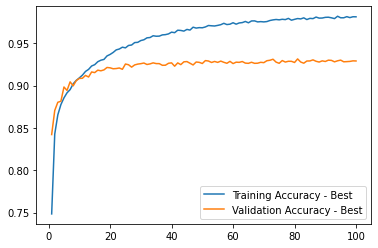

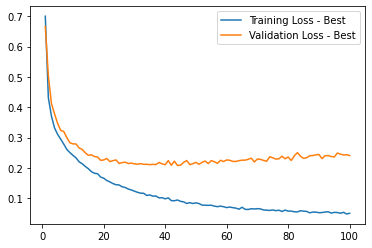

In [33]:
epoch_list = list(range(1, len(hist.history['accuracy']) + 1))
plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
plt.legend(("Training Accuracy - Best", "Validation Accuracy - Best"))
plt.show()

plt.plot(epoch_list, hist.history['loss'], epoch_list, hist.history['val_loss'])
plt.legend(("Training Loss - Best", "Validation Loss - Best"))
plt.show()

## Extra Test Section

In [34]:
#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#

###Test####

model_1 = Sequential()
model_1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 #kernel_initializer='he_normal',
                 input_shape=input_shape))
model_1.add(Dropout(0.7))
model_1.add(Activation('relu'))
model_1.add(Conv2D(64, kernel_size=(3,3)))
model_1.add(LeakyReLU(alpha=0.06))
model_1.add(Dropout(0.6))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Activation('relu'))
model_1.add(Flatten())
model_1.add(Dense(800))  
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation="softmax"))

my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]

In [35]:
# Flag to determine whether we use Keras' Image augmentation data generator
augmentation = False

#
# Compile the model so we can fit it. Researching loss functions and optimizers
# might be a good thing to do.
#
model_1.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

if not augmentation:
    #
    # Fit the model.  Once the model is trained we'll evaluate the performance.
    print('not using image augmentation')
    hist1 = model_1.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=my_callbacks)
else:
# fits the model on batches with real-time data augmentation:
    hist1 = model_1.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch=len(x_train) / batch_size, validation_data=(x_test, y_test),
                           epochs=epochs, verbose=1, callbacks=my_callbacks, workers = 2)


score_1 = model_1.evaluate(x_test, y_test)

#
# Predict on the test data and pass to metrics function
yhat = np.argmax(model_1.predict(x_test), axis=-1)
y_dec = decode_one_hot(y_test)

print("\nSUBMIT THIS BLOCK for the Competition\n")
print(metrics.classification_report(y_dec, yhat))
print("Testing Loss:", score_1[0])
print("Testing Accuracy:", score_1[1])
print("END SUBMISSION BLOCK\n")

model_1.summary()

not using image augmentation
Epoch 1/100
132/134 [============================>.] - ETA: 0s - loss: 0.9461 - accuracy: 0.6533

134/134 [==============================] - 5s 30ms/step - loss: 0.9421 - accuracy: 0.6546 - val_loss: 1.0850 - val_accuracy: 0.7523
Epoch 2/100
133/134 [============================>.] - ETA: 0s - loss: 0.6346 - accuracy: 0.7661

134/134 [==============================] - 4s 28ms/step - loss: 0.6341 - accuracy: 0.7664 - val_loss: 0.8895 - val_accuracy: 0.7981
Epoch 3/100
134/134 [==============================] - ETA: 0s - loss: 0.5546 - accuracy: 0.7956

134/134 [==============================] - 4s 29ms/step - loss: 0.5546 - accuracy: 0.7956 - val_loss: 0.7745 - val_accuracy: 0.8237
Epoch 4/100
134/134 [==============================] - ETA: 0s - loss: 0.5017 - accuracy: 0.8170

134/134 [==============================] - 4s 27ms/step - loss: 0.5017 - accuracy: 0.8170 - val_loss: 0.6910 - val_accuracy: 0.8368
Epoch 5/100
134/134 [==============================] - ETA: 0s - loss: 0.4718 - accuracy: 0.8291

134/134 [==============================] - 4s 29ms/step - loss: 0.4718 - accuracy: 0.8291 - val_loss: 0.6328 - val_accuracy: 0.8468
Epoch 6/100
132/134 [============================>.] - ETA: 0s - loss: 0.4451 - accuracy: 0.8373

134/134 [==============================] - 4s 29ms/step - loss: 0.4459 - accuracy: 0.8370 - val_loss: 0.5916 - val_accuracy: 0.8498
Epoch 7/100
132/134 [============================>.] - ETA: 0s - loss: 0.4246 - accuracy: 0.8441

134/134 [==============================] - 4s 27ms/step - loss: 0.4250 - accuracy: 0.8440 - val_loss: 0.5656 - val_accuracy: 0.8573
Epoch 8/100
132/134 [============================>.] - ETA: 0s - loss: 0.4079 - accuracy: 0.8514

134/134 [==============================] - 4s 28ms/step - loss: 0.4074 - accuracy: 0.8519 - val_loss: 0.5176 - val_accuracy: 0.8669
Epoch 9/100
134/134 [==============================] - ETA: 0s - loss: 0.3934 - accuracy: 0.8563

134/134 [==============================] - 4s 28ms/step - loss: 0.3934 - accuracy: 0.8563 - val_loss: 0.4917 - val_accuracy: 0.8691
Epoch 10/100
134/134 [==============================] - ETA: 0s - loss: 0.3813 - accuracy: 0.8606

134/134 [==============================] - 4s 28ms/step - loss: 0.3813 - accuracy: 0.8606 - val_loss: 0.4708 - val_accuracy: 0.8722
Epoch 11/100
134/134 [==============================] - ETA: 0s - loss: 0.3695 - accuracy: 0.8657

134/134 [==============================] - 4s 29ms/step - loss: 0.3695 - accuracy: 0.8657 - val_loss: 0.4559 - val_accuracy: 0.8744
Epoch 12/100
134/134 [==============================] - ETA: 0s - loss: 0.3581 - accuracy: 0.8705

134/134 [==============================] - 4s 27ms/step - loss: 0.3581 - accuracy: 0.8705 - val_loss: 0.4415 - val_accuracy: 0.8761
Epoch 13/100
134/134 [==============================] - ETA: 0s - loss: 0.3536 - accuracy: 0.8709

134/134 [==============================] - 4s 27ms/step - loss: 0.3536 - accuracy: 0.8709 - val_loss: 0.4371 - val_accuracy: 0.8839
Epoch 14/100
133/134 [============================>.] - ETA: 0s - loss: 0.3404 - accuracy: 0.8744

134/134 [==============================] - 4s 27ms/step - loss: 0.3403 - accuracy: 0.8745 - val_loss: 0.4187 - val_accuracy: 0.8852
Epoch 15/100
132/134 [============================>.] - ETA: 0s - loss: 0.3316 - accuracy: 0.8789

134/134 [==============================] - 4s 27ms/step - loss: 0.3316 - accuracy: 0.8788 - val_loss: 0.4026 - val_accuracy: 0.8874
Epoch 16/100
132/134 [============================>.] - ETA: 0s - loss: 0.3258 - accuracy: 0.8798

134/134 [==============================] - 4s 27ms/step - loss: 0.3264 - accuracy: 0.8796 - val_loss: 0.4022 - val_accuracy: 0.8886
Epoch 17/100
132/134 [============================>.] - ETA: 0s - loss: 0.3174 - accuracy: 0.8836

134/134 [==============================] - 4s 27ms/step - loss: 0.3174 - accuracy: 0.8836 - val_loss: 0.3860 - val_accuracy: 0.8903
Epoch 18/100
134/134 [==============================] - ETA: 0s - loss: 0.3137 - accuracy: 0.8850

134/134 [==============================] - 4s 27ms/step - loss: 0.3137 - accuracy: 0.8850 - val_loss: 0.3770 - val_accuracy: 0.8905
Epoch 19/100
134/134 [==============================] - ETA: 0s - loss: 0.3048 - accuracy: 0.8876

134/134 [==============================] - 4s 27ms/step - loss: 0.3048 - accuracy: 0.8876 - val_loss: 0.3786 - val_accuracy: 0.8892
Epoch 20/100
134/134 [==============================] - ETA: 0s - loss: 0.2982 - accuracy: 0.8911

134/134 [==============================] - 4s 27ms/step - loss: 0.2982 - accuracy: 0.8911 - val_loss: 0.3711 - val_accuracy: 0.8923
Epoch 21/100
134/134 [==============================] - ETA: 0s - loss: 0.2944 - accuracy: 0.8910

134/134 [==============================] - 4s 29ms/step - loss: 0.2944 - accuracy: 0.8910 - val_loss: 0.3605 - val_accuracy: 0.8944
Epoch 22/100
132/134 [============================>.] - ETA: 0s - loss: 0.2880 - accuracy: 0.8937

134/134 [==============================] - 4s 28ms/step - loss: 0.2883 - accuracy: 0.8936 - val_loss: 0.3635 - val_accuracy: 0.8954
Epoch 23/100
133/134 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.8954

134/134 [==============================] - 4s 29ms/step - loss: 0.2826 - accuracy: 0.8953 - val_loss: 0.3470 - val_accuracy: 0.8972
Epoch 24/100
134/134 [==============================] - ETA: 0s - loss: 0.2766 - accuracy: 0.8983

134/134 [==============================] - 4s 29ms/step - loss: 0.2766 - accuracy: 0.8983 - val_loss: 0.3422 - val_accuracy: 0.8975
Epoch 25/100
132/134 [============================>.] - ETA: 0s - loss: 0.2743 - accuracy: 0.8980

134/134 [==============================] - 4s 29ms/step - loss: 0.2746 - accuracy: 0.8979 - val_loss: 0.3452 - val_accuracy: 0.8994
Epoch 26/100
133/134 [============================>.] - ETA: 0s - loss: 0.2701 - accuracy: 0.9006

134/134 [==============================] - 4s 29ms/step - loss: 0.2698 - accuracy: 0.9007 - val_loss: 0.3366 - val_accuracy: 0.8999
Epoch 27/100
134/134 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.9016

134/134 [==============================] - 4s 28ms/step - loss: 0.2650 - accuracy: 0.9016 - val_loss: 0.3305 - val_accuracy: 0.9022
Epoch 28/100
133/134 [============================>.] - ETA: 0s - loss: 0.2591 - accuracy: 0.9049

134/134 [==============================] - 4s 29ms/step - loss: 0.2594 - accuracy: 0.9048 - val_loss: 0.3312 - val_accuracy: 0.9015
Epoch 29/100
132/134 [============================>.] - ETA: 0s - loss: 0.2540 - accuracy: 0.9069

134/134 [==============================] - 4s 27ms/step - loss: 0.2536 - accuracy: 0.9072 - val_loss: 0.3222 - val_accuracy: 0.9038
Epoch 30/100
133/134 [============================>.] - ETA: 0s - loss: 0.2528 - accuracy: 0.9071

134/134 [==============================] - 4s 27ms/step - loss: 0.2532 - accuracy: 0.9069 - val_loss: 0.3158 - val_accuracy: 0.9035
Epoch 31/100
133/134 [============================>.] - ETA: 0s - loss: 0.2483 - accuracy: 0.9079

134/134 [==============================] - 4s 28ms/step - loss: 0.2483 - accuracy: 0.9081 - val_loss: 0.3219 - val_accuracy: 0.9063
Epoch 32/100
134/134 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.9079

134/134 [==============================] - 4s 27ms/step - loss: 0.2472 - accuracy: 0.9079 - val_loss: 0.3118 - val_accuracy: 0.9049
Epoch 33/100
134/134 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 0.9113

134/134 [==============================] - 4s 27ms/step - loss: 0.2408 - accuracy: 0.9113 - val_loss: 0.3127 - val_accuracy: 0.9072
Epoch 34/100
134/134 [==============================] - ETA: 0s - loss: 0.2372 - accuracy: 0.9134

134/134 [==============================] - 4s 29ms/step - loss: 0.2372 - accuracy: 0.9134 - val_loss: 0.3096 - val_accuracy: 0.9068
Epoch 35/100
133/134 [============================>.] - ETA: 0s - loss: 0.2348 - accuracy: 0.9131

134/134 [==============================] - 4s 27ms/step - loss: 0.2346 - accuracy: 0.9133 - val_loss: 0.2998 - val_accuracy: 0.9077
Epoch 36/100
134/134 [==============================] - ETA: 0s - loss: 0.2302 - accuracy: 0.9149

134/134 [==============================] - 4s 27ms/step - loss: 0.2302 - accuracy: 0.9149 - val_loss: 0.3062 - val_accuracy: 0.9087
Epoch 37/100
134/134 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 0.9152

134/134 [==============================] - 4s 27ms/step - loss: 0.2268 - accuracy: 0.9152 - val_loss: 0.3063 - val_accuracy: 0.9088
Epoch 38/100
134/134 [==============================] - ETA: 0s - loss: 0.2235 - accuracy: 0.9180

134/134 [==============================] - 4s 27ms/step - loss: 0.2235 - accuracy: 0.9180 - val_loss: 0.2988 - val_accuracy: 0.9089
Epoch 39/100
132/134 [============================>.] - ETA: 0s - loss: 0.2195 - accuracy: 0.9187

134/134 [==============================] - 4s 29ms/step - loss: 0.2191 - accuracy: 0.9188 - val_loss: 0.2902 - val_accuracy: 0.9079
Epoch 40/100
134/134 [==============================] - ETA: 0s - loss: 0.2149 - accuracy: 0.9207

134/134 [==============================] - 4s 29ms/step - loss: 0.2149 - accuracy: 0.9207 - val_loss: 0.2882 - val_accuracy: 0.9103
Epoch 41/100
132/134 [============================>.] - ETA: 0s - loss: 0.2123 - accuracy: 0.9211

134/134 [==============================] - 4s 27ms/step - loss: 0.2127 - accuracy: 0.9209 - val_loss: 0.2869 - val_accuracy: 0.9116
Epoch 42/100
132/134 [============================>.] - ETA: 0s - loss: 0.2094 - accuracy: 0.9231

134/134 [==============================] - 4s 27ms/step - loss: 0.2097 - accuracy: 0.9229 - val_loss: 0.2819 - val_accuracy: 0.9112
Epoch 43/100
132/134 [============================>.] - ETA: 0s - loss: 0.2053 - accuracy: 0.9247

134/134 [==============================] - 4s 28ms/step - loss: 0.2051 - accuracy: 0.9248 - val_loss: 0.2846 - val_accuracy: 0.9086
Epoch 44/100
134/134 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9232

134/134 [==============================] - 4s 29ms/step - loss: 0.2063 - accuracy: 0.9232 - val_loss: 0.2821 - val_accuracy: 0.9128
Epoch 45/100
134/134 [==============================] - ETA: 0s - loss: 0.2006 - accuracy: 0.9259

134/134 [==============================] - 4s 27ms/step - loss: 0.2006 - accuracy: 0.9259 - val_loss: 0.2800 - val_accuracy: 0.9123
Epoch 46/100
132/134 [============================>.] - ETA: 0s - loss: 0.1999 - accuracy: 0.9263

134/134 [==============================] - 4s 29ms/step - loss: 0.1998 - accuracy: 0.9262 - val_loss: 0.2747 - val_accuracy: 0.9133
Epoch 47/100
133/134 [============================>.] - ETA: 0s - loss: 0.1979 - accuracy: 0.9268

134/134 [==============================] - 4s 29ms/step - loss: 0.1978 - accuracy: 0.9268 - val_loss: 0.2770 - val_accuracy: 0.9134
Epoch 48/100
133/134 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9292

134/134 [==============================] - 4s 27ms/step - loss: 0.1929 - accuracy: 0.9294 - val_loss: 0.2731 - val_accuracy: 0.9128
Epoch 49/100
133/134 [============================>.] - ETA: 0s - loss: 0.1925 - accuracy: 0.9290

134/134 [==============================] - 4s 27ms/step - loss: 0.1925 - accuracy: 0.9290 - val_loss: 0.2689 - val_accuracy: 0.9138
Epoch 50/100
134/134 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9294

134/134 [==============================] - 4s 29ms/step - loss: 0.1897 - accuracy: 0.9294 - val_loss: 0.2708 - val_accuracy: 0.9134
Epoch 51/100
133/134 [============================>.] - ETA: 0s - loss: 0.1845 - accuracy: 0.9306

134/134 [==============================] - 4s 28ms/step - loss: 0.1844 - accuracy: 0.9307 - val_loss: 0.2653 - val_accuracy: 0.9163
Epoch 52/100
133/134 [============================>.] - ETA: 0s - loss: 0.1841 - accuracy: 0.9317

134/134 [==============================] - 4s 29ms/step - loss: 0.1837 - accuracy: 0.9320 - val_loss: 0.2639 - val_accuracy: 0.9134
Epoch 53/100
132/134 [============================>.] - ETA: 0s - loss: 0.1825 - accuracy: 0.9319

134/134 [==============================] - 4s 28ms/step - loss: 0.1832 - accuracy: 0.9314 - val_loss: 0.2636 - val_accuracy: 0.9136
Epoch 54/100
133/134 [============================>.] - ETA: 0s - loss: 0.1791 - accuracy: 0.9324

134/134 [==============================] - 4s 29ms/step - loss: 0.1789 - accuracy: 0.9324 - val_loss: 0.2601 - val_accuracy: 0.9157
Epoch 55/100
134/134 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.9343

134/134 [==============================] - 4s 29ms/step - loss: 0.1783 - accuracy: 0.9343 - val_loss: 0.2570 - val_accuracy: 0.9143
Epoch 56/100
133/134 [============================>.] - ETA: 0s - loss: 0.1753 - accuracy: 0.9343

134/134 [==============================] - 4s 29ms/step - loss: 0.1753 - accuracy: 0.9343 - val_loss: 0.2577 - val_accuracy: 0.9165
Epoch 57/100
134/134 [==============================] - ETA: 0s - loss: 0.1719 - accuracy: 0.9361

134/134 [==============================] - 4s 29ms/step - loss: 0.1719 - accuracy: 0.9361 - val_loss: 0.2517 - val_accuracy: 0.9176
Epoch 58/100
134/134 [==============================] - ETA: 0s - loss: 0.1713 - accuracy: 0.9370

134/134 [==============================] - 4s 29ms/step - loss: 0.1713 - accuracy: 0.9370 - val_loss: 0.2546 - val_accuracy: 0.9177
Epoch 59/100
132/134 [============================>.] - ETA: 0s - loss: 0.1659 - accuracy: 0.9385

134/134 [==============================] - 4s 27ms/step - loss: 0.1661 - accuracy: 0.9385 - val_loss: 0.2572 - val_accuracy: 0.9160
Epoch 60/100
132/134 [============================>.] - ETA: 0s - loss: 0.1660 - accuracy: 0.9374

134/134 [==============================] - 4s 29ms/step - loss: 0.1665 - accuracy: 0.9371 - val_loss: 0.2512 - val_accuracy: 0.9167
Epoch 61/100
134/134 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.9392

134/134 [==============================] - 4s 27ms/step - loss: 0.1642 - accuracy: 0.9392 - val_loss: 0.2510 - val_accuracy: 0.9171
Epoch 62/100
134/134 [==============================] - ETA: 0s - loss: 0.1579 - accuracy: 0.9421

134/134 [==============================] - 4s 29ms/step - loss: 0.1579 - accuracy: 0.9421 - val_loss: 0.2496 - val_accuracy: 0.9156
Epoch 63/100
133/134 [============================>.] - ETA: 0s - loss: 0.1578 - accuracy: 0.9412

134/134 [==============================] - 4s 29ms/step - loss: 0.1578 - accuracy: 0.9411 - val_loss: 0.2468 - val_accuracy: 0.9175
Epoch 64/100
132/134 [============================>.] - ETA: 0s - loss: 0.1578 - accuracy: 0.9402

134/134 [==============================] - 4s 29ms/step - loss: 0.1573 - accuracy: 0.9405 - val_loss: 0.2461 - val_accuracy: 0.9176
Epoch 65/100
133/134 [============================>.] - ETA: 0s - loss: 0.1570 - accuracy: 0.9421

134/134 [==============================] - 4s 29ms/step - loss: 0.1570 - accuracy: 0.9423 - val_loss: 0.2462 - val_accuracy: 0.9176
Epoch 66/100
133/134 [============================>.] - ETA: 0s - loss: 0.1504 - accuracy: 0.9434

134/134 [==============================] - 4s 27ms/step - loss: 0.1503 - accuracy: 0.9435 - val_loss: 0.2448 - val_accuracy: 0.9186
Epoch 67/100
134/134 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.9441

134/134 [==============================] - 4s 27ms/step - loss: 0.1501 - accuracy: 0.9441 - val_loss: 0.2426 - val_accuracy: 0.9191
Epoch 68/100
134/134 [==============================] - ETA: 0s - loss: 0.1477 - accuracy: 0.9458

134/134 [==============================] - 4s 28ms/step - loss: 0.1477 - accuracy: 0.9458 - val_loss: 0.2393 - val_accuracy: 0.9195
Epoch 69/100
132/134 [============================>.] - ETA: 0s - loss: 0.1447 - accuracy: 0.9466

134/134 [==============================] - 4s 27ms/step - loss: 0.1442 - accuracy: 0.9469 - val_loss: 0.2422 - val_accuracy: 0.9173
Epoch 70/100
133/134 [============================>.] - ETA: 0s - loss: 0.1449 - accuracy: 0.9468

134/134 [==============================] - 4s 27ms/step - loss: 0.1445 - accuracy: 0.9469 - val_loss: 0.2418 - val_accuracy: 0.9176
Epoch 71/100
132/134 [============================>.] - ETA: 0s - loss: 0.1427 - accuracy: 0.9467

134/134 [==============================] - 4s 27ms/step - loss: 0.1436 - accuracy: 0.9463 - val_loss: 0.2407 - val_accuracy: 0.9193
Epoch 72/100
134/134 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 0.9488

134/134 [==============================] - 4s 29ms/step - loss: 0.1411 - accuracy: 0.9488 - val_loss: 0.2386 - val_accuracy: 0.9194
Epoch 73/100
134/134 [==============================] - ETA: 0s - loss: 0.1419 - accuracy: 0.9474

134/134 [==============================] - 4s 29ms/step - loss: 0.1419 - accuracy: 0.9474 - val_loss: 0.2345 - val_accuracy: 0.9204
Epoch 74/100
132/134 [============================>.] - ETA: 0s - loss: 0.1344 - accuracy: 0.9499

134/134 [==============================] - 4s 29ms/step - loss: 0.1342 - accuracy: 0.9499 - val_loss: 0.2371 - val_accuracy: 0.9193
Epoch 75/100
132/134 [============================>.] - ETA: 0s - loss: 0.1357 - accuracy: 0.9492

134/134 [==============================] - 4s 29ms/step - loss: 0.1357 - accuracy: 0.9493 - val_loss: 0.2393 - val_accuracy: 0.9183
Epoch 76/100
133/134 [============================>.] - ETA: 0s - loss: 0.1353 - accuracy: 0.9495

134/134 [==============================] - 4s 27ms/step - loss: 0.1350 - accuracy: 0.9498 - val_loss: 0.2334 - val_accuracy: 0.9196
Epoch 77/100
132/134 [============================>.] - ETA: 0s - loss: 0.1303 - accuracy: 0.9513

134/134 [==============================] - 4s 27ms/step - loss: 0.1300 - accuracy: 0.9514 - val_loss: 0.2317 - val_accuracy: 0.9192
Epoch 78/100
134/134 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.9513

134/134 [==============================] - 4s 29ms/step - loss: 0.1302 - accuracy: 0.9513 - val_loss: 0.2345 - val_accuracy: 0.9200
Epoch 79/100
133/134 [============================>.] - ETA: 0s - loss: 0.1292 - accuracy: 0.9524

134/134 [==============================] - 4s 27ms/step - loss: 0.1292 - accuracy: 0.9524 - val_loss: 0.2320 - val_accuracy: 0.9205
Epoch 80/100
134/134 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9514

134/134 [==============================] - 4s 27ms/step - loss: 0.1282 - accuracy: 0.9514 - val_loss: 0.2319 - val_accuracy: 0.9215
Epoch 81/100
132/134 [============================>.] - ETA: 0s - loss: 0.1245 - accuracy: 0.9539

134/134 [==============================] - 4s 29ms/step - loss: 0.1250 - accuracy: 0.9538 - val_loss: 0.2319 - val_accuracy: 0.9212
Epoch 82/100
133/134 [============================>.] - ETA: 0s - loss: 0.1257 - accuracy: 0.9523

134/134 [==============================] - 4s 27ms/step - loss: 0.1259 - accuracy: 0.9521 - val_loss: 0.2309 - val_accuracy: 0.9199
Epoch 83/100
134/134 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9544

134/134 [==============================] - 4s 28ms/step - loss: 0.1223 - accuracy: 0.9544 - val_loss: 0.2313 - val_accuracy: 0.9214
Epoch 84/100
133/134 [============================>.] - ETA: 0s - loss: 0.1207 - accuracy: 0.9536

134/134 [==============================] - 4s 29ms/step - loss: 0.1206 - accuracy: 0.9537 - val_loss: 0.2298 - val_accuracy: 0.9208
Epoch 85/100
133/134 [============================>.] - ETA: 0s - loss: 0.1200 - accuracy: 0.9552

134/134 [==============================] - 4s 27ms/step - loss: 0.1200 - accuracy: 0.9552 - val_loss: 0.2271 - val_accuracy: 0.9230
Epoch 86/100
134/134 [==============================] - ETA: 0s - loss: 0.1147 - accuracy: 0.9570

134/134 [==============================] - 4s 29ms/step - loss: 0.1147 - accuracy: 0.9570 - val_loss: 0.2272 - val_accuracy: 0.9219
Epoch 87/100
132/134 [============================>.] - ETA: 0s - loss: 0.1180 - accuracy: 0.9556

134/134 [==============================] - 4s 28ms/step - loss: 0.1177 - accuracy: 0.9557 - val_loss: 0.2269 - val_accuracy: 0.9216
Epoch 88/100
132/134 [============================>.] - ETA: 0s - loss: 0.1134 - accuracy: 0.9578

134/134 [==============================] - 4s 27ms/step - loss: 0.1139 - accuracy: 0.9577 - val_loss: 0.2269 - val_accuracy: 0.9202
Epoch 89/100
134/134 [==============================] - ETA: 0s - loss: 0.1174 - accuracy: 0.9548

134/134 [==============================] - 4s 29ms/step - loss: 0.1174 - accuracy: 0.9548 - val_loss: 0.2274 - val_accuracy: 0.9220
Epoch 90/100
133/134 [============================>.] - ETA: 0s - loss: 0.1131 - accuracy: 0.9575

134/134 [==============================] - 4s 29ms/step - loss: 0.1131 - accuracy: 0.9575 - val_loss: 0.2239 - val_accuracy: 0.9221
Epoch 91/100
133/134 [============================>.] - ETA: 0s - loss: 0.1132 - accuracy: 0.9583

134/134 [==============================] - 4s 29ms/step - loss: 0.1133 - accuracy: 0.9582 - val_loss: 0.2241 - val_accuracy: 0.9215
Epoch 92/100
134/134 [==============================] - ETA: 0s - loss: 0.1116 - accuracy: 0.9581

134/134 [==============================] - 4s 27ms/step - loss: 0.1116 - accuracy: 0.9581 - val_loss: 0.2229 - val_accuracy: 0.9216
Epoch 93/100
133/134 [============================>.] - ETA: 0s - loss: 0.1096 - accuracy: 0.9602

134/134 [==============================] - 4s 29ms/step - loss: 0.1096 - accuracy: 0.9602 - val_loss: 0.2250 - val_accuracy: 0.9231
Epoch 94/100
134/134 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.9603

134/134 [==============================] - 4s 28ms/step - loss: 0.1054 - accuracy: 0.9603 - val_loss: 0.2216 - val_accuracy: 0.9231
Epoch 95/100
133/134 [============================>.] - ETA: 0s - loss: 0.1054 - accuracy: 0.9602

134/134 [==============================] - 4s 29ms/step - loss: 0.1054 - accuracy: 0.9602 - val_loss: 0.2226 - val_accuracy: 0.9229
Epoch 96/100
134/134 [==============================] - ETA: 0s - loss: 0.1036 - accuracy: 0.9619

134/134 [==============================] - 4s 29ms/step - loss: 0.1036 - accuracy: 0.9619 - val_loss: 0.2228 - val_accuracy: 0.9223
Epoch 97/100
134/134 [==============================] - ETA: 0s - loss: 0.1061 - accuracy: 0.9595

134/134 [==============================] - 4s 27ms/step - loss: 0.1061 - accuracy: 0.9595 - val_loss: 0.2257 - val_accuracy: 0.9204
Epoch 98/100
133/134 [============================>.] - ETA: 0s - loss: 0.1049 - accuracy: 0.9604

134/134 [==============================] - 4s 27ms/step - loss: 0.1048 - accuracy: 0.9604 - val_loss: 0.2194 - val_accuracy: 0.9233
Epoch 99/100
134/134 [==============================] - ETA: 0s - loss: 0.1016 - accuracy: 0.9627

134/134 [==============================] - 4s 28ms/step - loss: 0.1016 - accuracy: 0.9627 - val_loss: 0.2259 - val_accuracy: 0.9222
Epoch 100/100
133/134 [============================>.] - ETA: 0s - loss: 0.1015 - accuracy: 0.9627

619/619 [==============================] - 2s 4ms/step - loss: 0.2234 - accuracy: 0.9219

SUBMIT THIS BLOCK for the Competition

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      2051
           1       0.98      0.99      0.98      1956
           2       0.86      0.89      0.87      2013
           3       0.91      0.93      0.92      2008
           4       0.89      0.86      0.87      2031
           5       0.99      0.98      0.98      1923
           6       0.81      0.76      0.78      1952
           7       0.96      0.97      0.97      1920
           8       0.98      0.98      0.98      1911
           9       0.97      0.97      0.97      2035

    accuracy                           0.92     19800
   macro avg       0.92      0.92      0.92     19800
weighted avg       0.92      0.92      0.92     19800

Testing Loss: 0.22344011068344116
Testing Accuracy: 0.9219191670417786
END SUBMISSION BLOCK

Model: "sequential_

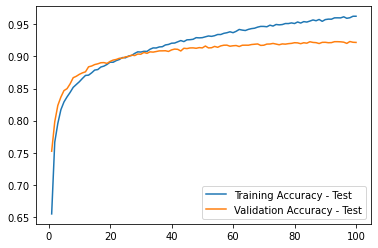

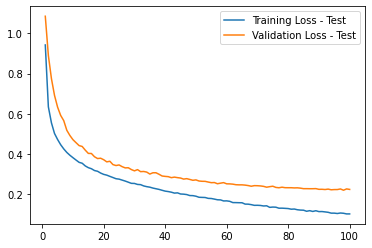

In [36]:
epoch_list_1 = list(range(1, len(hist1.history['accuracy']) + 1))
plt.plot(epoch_list_1, hist1.history['accuracy'], epoch_list_1, hist1.history['val_accuracy'])
plt.legend(("Training Accuracy - Test", "Validation Accuracy - Test"))
plt.show()

plt.plot(epoch_list_1, hist1.history['loss'], epoch_list_1, hist1.history['val_loss'])
plt.legend(("Training Loss - Test", "Validation Loss - Test"))
plt.show()

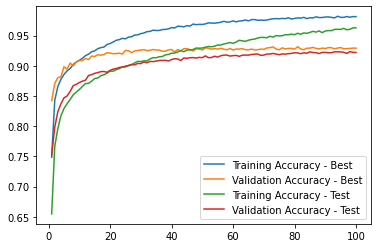

Testing Accuracy - Best: 0.9290909171104431
Testing Accuracy - Test: 0.9219191670417786


In [37]:
#Compare

plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
plt.plot(epoch_list_1, hist1.history['accuracy'], epoch_list_1, hist1.history['val_accuracy'])
plt.legend(("Training Accuracy - Best", "Validation Accuracy - Best", "Training Accuracy - Test", "Validation Accuracy - Test"))
plt.show()

#plt.plot(epoch_list_1, hist1.history['loss'], epoch_list_1, hist1.history['val_loss'])
#plt.legend(("Training Loss - Test", "Validation Loss - Test"))
#plt.show()


print("Testing Accuracy - Best:", score[1])
print("Testing Accuracy - Test:", score_1[1])

## Visualization of Performance on the Test Set

Here is a visualization of how well our classifier can do inference.

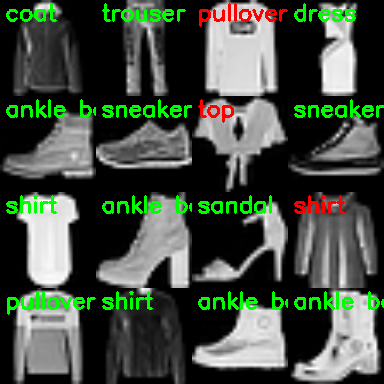

-1

In [38]:
import cv2
from imutils import build_montages
from google.colab.patches import cv2_imshow

# initialize our list of output images
images = []

labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
 
# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
	# classify the clothing
	probs = model.predict(x_test[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
 
	# extract the image from the testData if using "channels_first"
	# ordering
	if K.image_data_format() == "channels_first":
		image = (x_test[i][0] * 255).astype("uint8")
 
	# otherwise we are using "channels_last" ordering
	else:
		image = (x_test[i] * 255).astype("uint8")
    # initialize the text label color as green (correct)
	color = (0, 255, 0)
 
	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(y_test[i]):
		color = (0, 0, 255)
 
	# merge the channels into one image and resize the image from
	# 28x28 to 96x96 so we can better see it and then draw the
	# predicted label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
 
	# add the image to our list of output images
	images.append(image)
# construct the montage for the images
montage = build_montages(images, (96, 96), (4, 4))[0]
 
# show the output montage
cv2_imshow( montage)
cv2.waitKey(0)

In [39]:

#Need to check 50/200
#epochs = 50                 # Number of Training Epochs
#num_classes = 10            # This is the number of classes in the Fashion MNIST dataset
#batch_size = 200          # This parameter can be adjusted
#img_rows, img_cols = 28, 28 # Pixel sizes of the Images in the Dataset

#Current Best
epochs = 40                 # Number of Training Epochs
num_classes = 10            # This is the number of classes in the Fashion MNIST dataset
batch_size = 300          # This parameter can be adjusted
img_rows, img_cols = 28, 28 # Pixel sizes of the Images in the Dataset

#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#

###Test####

model_1 = Sequential()
model_1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 #kernel_initializer='he_normal',
                 input_shape=input_shape))
model_1.add(Dropout(0.7))
model_1.add(Activation('relu'))
model_1.add(Conv2D(64, kernel_size=(3,3)))
model_1.add(LeakyReLU(alpha=0.05))
model_1.add(Dropout(0.6))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Activation('relu'))
model_1.add(Flatten())
model_1.add(Dense(1000))  
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation="softmax"))

my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]


#Testing Accuracy - Test: 0.9271717071533203